In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q -U git+https://github.com/sbrugman/SDGym.git@v0.2.2-hw

In [ ]:
!pip install -q -U ../../

In [2]:
from timeit import default_timer as timer
from functools import partial
from random import choices
import logging

In [3]:
import sdgym
from sdgym import load_dataset
from sdgym import benchmark
from sdgym import load_dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
import pgmpy

from pgmpy.models import BayesianModel
from pgmpy.estimators import TreeSearch, HillClimbSearch, BicScore, ExhaustiveSearch, BayesianEstimator
from pgmpy.sampling import BayesianModelSampling

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

In [8]:
from sklearn.metrics import (
    mutual_info_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
)

In [9]:
from scipy import interpolate

In [10]:
from phik.phik import phik_from_binned_array

In [11]:
from synthsonic.models.kde_utils import kde_smooth_peaks_1dim, kde_smooth_peaks
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
logging.basicConfig(level=logging.INFO)

In [14]:
dataset_name = 'asia'

In [15]:
data, categorical_columns, ordinal_columns = load_dataset(dataset_name)

INFO:sdgym.data:Loading dataset asia (all variables)


In [16]:
data.shape

(10000, 8)

In [17]:
categorical_columns, ordinal_columns

([0, 1, 2, 3, 4, 5, 6, 7], [])

In [18]:
for i in range(data.shape[1]):
    print (i, len(np.unique(data[:, i])))

0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2


(array([4425.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 5575.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <a list of 40 Patch objects>)

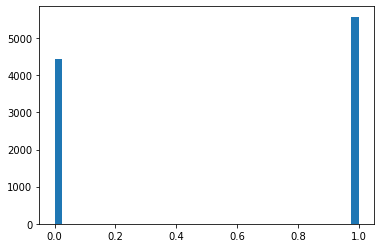

In [19]:
plt.hist(data[:, 7], bins=40)

In [20]:
data[:, 0]

array([1., 1., 1., ..., 1., 1., 1.])

# run sdgym

In [21]:
def KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns):
    all_features = list(range(real_data.shape[1]))
    numerical_features = list(set(all_features) - set(categorical_columns + ordinal_columns))
    data = np.float64(real_data)
    
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    clf = xgb.XGBClassifier(
        n_estimators=250,
        reg_lambda=1,
        gamma=0,
        max_depth=9
    )
#     clf = MLPClassifier(alpha=0.1, random_state=0, max_iter=1000, early_stopping=True)
    
    kde = KDECopulaNNPdf(
        use_KDE=False, 
        categorical_columns=categorical_columns+ordinal_columns,
        distinct_threshold=-1,
        n_uniform_bins=30,
        n_calibration_bins=100,
        test_size=0.35,
#        edge_weights_fn=phik_from_binned_array # normalized_mutual_info_score
#        clf=clf,
#         ordering='mi',
    )
    kde = kde.fit(data)
    
#     X_gen, sample_weight = kde.sample(n_samples)
    X_gen = kde.sample_no_weights(n_samples, show_progress=True)
    
    X_gen[:, categorical_columns+ordinal_columns] = np.round(X_gen[:, categorical_columns+ordinal_columns])
    X_gen = np.float32(X_gen)
    
    print(X_gen[:, :5])

    return X_gen

In [22]:
def KDECopulaNNPdf_SynthesizerInteger(real_data, categorical_columns, ordinal_columns):
    """Census has integer only..."""
    data = KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns)
    data = np.round(data)
    
    print(data[:, :5])

    return data

In [23]:
from sdgym.synthesizers import (
    CLBNSynthesizer, CTGANSynthesizer, IdentitySynthesizer, IndependentSynthesizer,
    MedganSynthesizer, PrivBNSynthesizer, TableganSynthesizer, TVAESynthesizer,
    UniformSynthesizer, VEEGANSynthesizer)

all_synthesizers = [
    #IdentitySynthesizer,
    #IndependentSynthesizer,
    #KDECopulaNNPdf_Synthesizer,
    KDECopulaNNPdf_SynthesizerInteger,
]

In [24]:
scores = sdgym.run(synthesizers=all_synthesizers, datasets=[dataset_name], iterations=1)

INFO:sdgym.benchmark:0%|          | 0/1 [00:00<?, ?it/s]
INFO:sdgym.benchmark:Evaluating KDECopulaNNPdf_SynthesizerInteger on dataset asia; iteration 0; 269.14 MB
INFO:sdgym.data:Loading dataset asia (all variables)
INFO:sdgym.benchmark:Running KDECopulaNNPdf_SynthesizerInteger on dataset asia; iteration 0; 270.66 MB
INFO:KDECopulaNNPdf:Processing 0 numerical and 8 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).

  0%|          | 0/21.0 [00:00<?, ?it/s]
Building tree: 100%|██████████| 21/21.0 [00:00<00:00, 1568.08it/s]
INFO:KDECopulaNNPdf:Configuring classifier.
INFO:KDECopulaNNPdf:Generating 256500 data points.

Generating for node: 6: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]
INFO:KDECopulaNNPdf:Fitting discriminative learner: selected 8 features.
INFO:KDECopulaNNPdf:Calibrating classifier.
INFO:KDECopulaNNPdf:Maximum weight found: 5.3908358947264565
INFO:KDECopulaNNPdf:Generating 52547 data poi

[[1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1.]
 ...
 [1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1.]]
[[1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1.]
 ...
 [1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1.]]


INFO:sdgym.benchmark:Finished KDECopulaNNPdf_SynthesizerInteger on dataset asia; iteration 0; 292.67 MB
INFO:sdgym.benchmark:100%|##########| 1/1 [00:04<00:00,  4.88s/it]


In [25]:
scores

,asia/syn_likelihood,asia/test_likelihood,timestamp
VEEGANSynthesizer,-11.492287,-5.952712,2020-04-12 09:41:35.096775
CLBNSynthesizer,-2.402547,-2.273804,2020-10-17 09:46:54.494331
CTGAN,-4.187960,-2.455444,2020-10-17 09:46:54.494331
CTGANSynthesizer,-2.693441,-2.311810,2020-10-17 09:46:54.494331
CopulaGAN,-3.956071,-2.404007,2020-10-17 09:46:54.494331
GaussianCopulaCategorical,-2.248123,-3.612161,2020-10-17 09:46:54.494331
GaussianCopulaCategoricalFuzzy,-2.829653,-3.108912,2020-10-17 09:46:54.494331
GaussianCopulaOneHot,-2.313891,-3.226644,2020-10-17 09:46:54.494331
IdentitySynthesizer,-2.235274,-2.241881,2020-10-17 09:46:54.494331
IndependentSynthesizer,-4.968752,-2.988754,2020-10-17 09:46:54.494331


In [26]:
scores.tail(4)

,asia/syn_likelihood,asia/test_likelihood,timestamp
TVAESynthesizer,-2.293483,-2.266323,2020-10-17 09:46:54.494331
TableganSynthesizer,-3.400135,-2.720815,2020-10-17 09:46:54.494331
UniformSynthesizer,-14.284941,-5.520020,2020-10-17 09:46:54.494331
KDECopulaNNPdf_SynthesizerInteger,-2.244890,-2.240180,2021-05-18 06:55:11.961133
